In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import asyncio
import random
import time

In [2]:
# Graph representing the true network topology, with weights representing bandwidth and current usage.
# Assume the path delay is all the same

G = nx.Graph()
routers = {}
router_ids = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
ref_bandwidth = 3

# Add nodes (routers) to the graph
G.add_nodes_from(router_ids)

# Add edges (links between routers) with weights (costs)
G.add_edge('A', 'B', band=4, usage = 0)
G.add_edge('A', 'C', band=3, usage = 0)
G.add_edge('B', 'C', band=3, usage = 0)
G.add_edge('B', 'D', band=5, usage = 0)
G.add_edge('C', 'D', band=4, usage = 0)
G.add_edge('C', 'E', band=2, usage = 0)
G.add_edge('D', 'E', band=3, usage = 0)
G.add_edge('E', 'F', band=2, usage = 0)
G.add_edge('D', 'F', band=3, usage = 0)
G.add_edge('I', 'L', band=3, usage = 0)
G.add_edge('E', 'G', band=2, usage = 0)
G.add_edge('D', 'G', band=3, usage = 0)
G.add_edge('G', 'H', band=2, usage = 0)
G.add_edge('G', 'I', band=3, usage = 0)
G.add_edge('F', 'J', band=3, usage = 0)
G.add_edge('J', 'K', band=3, usage = 0)
G.add_edge('J', 'C', band=3, usage = 0)
G.add_edge('K', 'L', band=3, usage = 0)
G.add_edge('A', 'L', band=3, usage = 0)

def reset_usage():
    for u, v, data in G.edges(data=True):
        data['usage'] = 0

# Plot the graph topology and relevant information
def plot_topo():
    np.random.seed(20)
    
    pos = nx.spring_layout(G)  # Define node positions using a spring layout
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'band')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Bandwidth")
    plt.show()

    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
    labels = nx.get_edge_attributes(G, 'usage')  # Get edge weights as labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
    plt.title("Network Topology Usage")
    plt.show()

    total_band = sum(data['band'] for u, v, data in G.edges(data=True))
    total_usage = sum(data['usage'] for u, v, data in G.edges(data=True))

    print(f"Total band: {total_band}, Total usage: {total_usage}, Link utilization: {round(total_usage/total_band,3)}")
    
    #Router info
    sleeping = 0
    packets_sending = 0
    packets_lost = 0
    for id in routers:
        if routers[id].sleep:
            sleeping += 1
        packets_sending += len(routers[id].packet_dest)
        packets_lost += routers[id].packet_loss
    print(f"Total routers: {len(routers)}, Sleeping: {sleeping}")
    print(f"Packets sent: {packets_sending}, Packets lost: {packets_lost}")

In [3]:
from Router import Router, OSPFRouter, GOSPFRouter
from Link import Link
from Packet import Packet, T1LSA, LSA

In [7]:
class Network:
    def __init__(self) -> None:
        self.nodes = []
        self.links = []
        self.interfaces_active = {}
        self.throughput_energy_constant = 0.0000001
        self.active_interface_constant = 10
        self.idle_interface_constant = 8
        self.sleep_interface_constant = 0.16
        self.swap_state_constant = 20
        self.link_states = {}
        self.network_state = nx.Graph()
    
    def get_link_states(self):
        for link in self.links:
            self.link_states[link.get_id()] = link.active
        return self.link_states
    
    def update_interface_states(self):
        for node in self.nodes:
            node.update_interface_statuses()
            for i, activity in enumerate(node.interface_status):
                self.interfaces_active[f"{node}{i}"] = activity
            
    def get_network_state(self):
        network_state = nx.Graph()
        for node in self.nodes:
            network_state.add_node(node.router_id)
        for link in self.links:
            network_state.add_edge(link.terminal1.router_id, link.terminal2.router_id, cost=OSPFRouter.link_cost(link.bandwidth), active=link.active)
        
        return network_state
    
    def get_active_network_state(self):
        network_state = nx.Graph()
        for node in self.nodes:
            network_state.add_node(node.router_id)
        for link in self.links:
            if link.active:
                network_state.add_edge(link.terminal1.router_id, link.terminal2.router_id, cost=OSPFRouter.link_cost(link.bandwidth))
        
        return network_state

    def add_node(self, node):
        self.nodes.append(node)
    
    def add_link(self, link):
        self.links.append(link)
        # self.interfaces_active[f"{link.terminal1}{link.interface1}"] = True
        # self.interfaces_active[f"{link.terminal2}{link.interface2}"] = True
    
    # def remove_link(self, link):
        # self.interfaces_active[f"{link.terminal1}{link.interface1}"] = False
        # self.interfaces_active[f"{link.terminal2}{link.interface2}"] = False

        # for i, l in enumerate(self.links):
        #     if l == link: self.links_active[i] = False
        #     return
    
    def get_total_throughput(self, reset_activity=True):
        total_throughput = 0
        for link in self.links:
            # print(link)
            # print(link.get_link_throughput())
            total_throughput += link.get_link_throughput(reset_activity)
        return total_throughput
    
    def calculate_interface_energy(self):
        sum_ = 0
        for activity in self.interfaces_active.values():
            if activity == OSPFRouter.ACTIVE: sum_ += self.active_interface_constant    
            elif activity == OSPFRouter.IDLE: sum_ += self.idle_interface_constant
            elif activity == OSPFRouter.SLEEP: sum_ += self.sleep_interface_constant
        return sum_
    
    def get_dropped_packets(self):
        sum_ = 0
        for link in self.links:
            sum_ += link.sample_dropped_packets()
        return sum_

    def get_total_energy(self, reset_activity=True):
        self.update_interface_states()
        throughput_energy = self.throughput_energy_constant * self.get_total_throughput(reset_activity)
        interface_energy = self.calculate_interface_energy()
        return throughput_energy + interface_energy

class GOSPFNetwork(Network):
    def __init__(self) -> None:
        super().__init__()
    
    def calculate_interface_energy(self):
        sum_energy = super().calculate_interface_energy()
        for node in self.nodes:
            sum_energy += node.get_switches() * self.swap_state_constant
        return sum_energy
        
    # def get_interface_status(self):
    #     interface_list = {}
    #     for node in self.nodes:
    #         interfaces = node.interface_active
    #         for i_no, activity in enumerate(interfaces):
    #             interface_list[f"{node}{i_no}"] = activity
    #     return interface_list
            

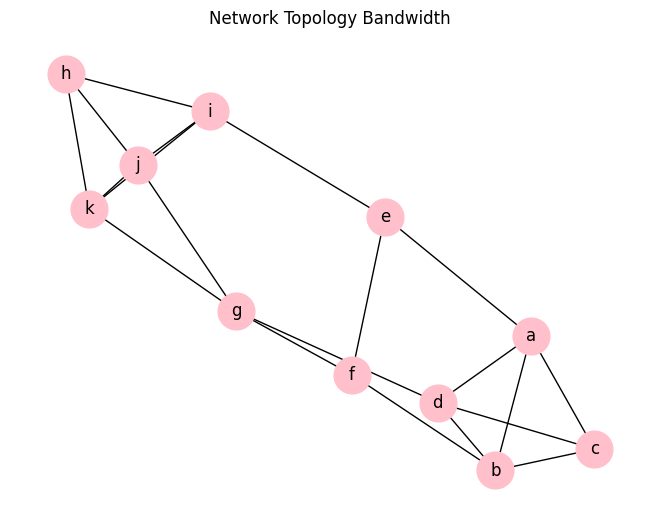

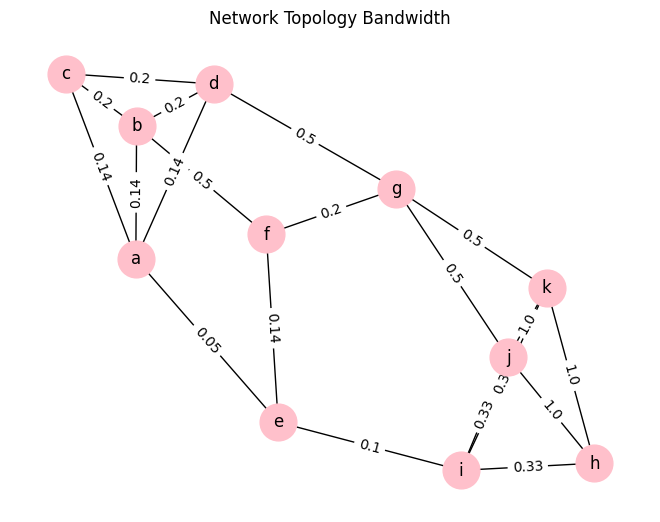

In [8]:
a = GOSPFRouter("a", n_interfaces=4)
b = GOSPFRouter("b", n_interfaces=4)
c = GOSPFRouter("c", n_interfaces=4)
d = GOSPFRouter("d", n_interfaces=4)
e = GOSPFRouter("e", n_interfaces=4)
f = GOSPFRouter("f", n_interfaces=4)
g = GOSPFRouter("g", n_interfaces=8)
h = GOSPFRouter("h", n_interfaces=4)
i = GOSPFRouter("i", n_interfaces=4)
j = GOSPFRouter("j", n_interfaces=4)
k = GOSPFRouter("k", n_interfaces=4)

nodes = [a, b, c, d, e, f, g, h, i, j, k]
ab = Link(7_000_000)
ac = Link(7_000_000)
ad = Link(7_000_000)

ae = Link(20_000_000)

bc = Link(5_000_000)
bd = Link(5_000_000)
cd = Link(5_000_000)

ef = Link(7_000_000)

ei = Link(10_000_000)

fg = Link(5_000_000)

bf = Link(2_000_000)
dg = Link(2_000_000)

ih = Link(3_000_000)
ij = Link(3_000_000)
ik = Link(3_000_000)

hk = Link(1_000_000)
hj = Link(1_000_000)
jk = Link(1_000_000)

jg = Link(2_000_000)
kg = Link(2_000_000)


ab.create_link(a, 0, b, 0)
ac.create_link(a, 1, c, 0)
ad.create_link(a, 2, d, 0)
ae.create_link(a, 3, e, 0)

bc.create_link(b, 1, c, 1)
bd.create_link(b, 2, d, 1)
cd.create_link(c, 2, d, 2)

ef.create_link(e, 1, f, 0)
ei.create_link(e, 2, i, 0)

fg.create_link(f, 1, g, 1)

bf.create_link(b, 3, f, 2)
dg.create_link(d, 3, g, 2)

ih.create_link(i, 1, h, 0)
ij.create_link(i, 2, j, 0)
ik.create_link(i, 3, k, 0)
hk.create_link(h, 1, k, 1)
hj.create_link(h, 2, j, 1)
jk.create_link(j, 2, k, 2)
jg.create_link(j, 3, g, 3)
kg.create_link(k, 3, g, 4)


links = [ab, ac, ad, ae, bc, bd, cd, ef, ei, fg, bf, dg, ih, ij, ik, hk, hj, jk, jg, kg]

net = GOSPFNetwork()
for node in nodes:
    net.add_node(node)

for link in links:
    net.add_link(link)

G = net.get_network_state()
pos = nx.spring_layout(G)  # Define node positions using a spring layout
nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
labels = nx.get_edge_attributes(G, 'band')  # Get edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  # Draw edge labels
plt.title("Network Topology Bandwidth")
plt.show()

a = OSPFRouter("a", n_interfaces=4)
b = OSPFRouter("b", n_interfaces=4)
c = OSPFRouter("c", n_interfaces=4)
d = OSPFRouter("d", n_interfaces=4)
e = OSPFRouter("e", n_interfaces=4)
f = OSPFRouter("f", n_interfaces=4)
g = OSPFRouter("g", n_interfaces=8)
h = OSPFRouter("h", n_interfaces=4)
i = OSPFRouter("i", n_interfaces=4)
j = OSPFRouter("j", n_interfaces=4)
k = OSPFRouter("k", n_interfaces=4)

ospf_nodes = [a, b, c, d, e, f, g, h, i, j, k]
ab = Link(7_000_000)
ac = Link(7_000_000)
ad = Link(7_000_000)

ae = Link(20_000_000)

bc = Link(5_000_000)
bd = Link(5_000_000)
cd = Link(5_000_000)

ef = Link(7_000_000)

ei = Link(10_000_000)

fg = Link(5_000_000)

bf = Link(2_000_000)
dg = Link(2_000_000)

ih = Link(3_000_000)
ij = Link(3_000_000)
ik = Link(3_000_000)

hk = Link(1_000_000)
hj = Link(1_000_000)
jk = Link(1_000_000)

jg = Link(2_000_000)
kg = Link(2_000_000)


ab.create_link(a, 0, b, 0)
ac.create_link(a, 1, c, 0)
ad.create_link(a, 2, d, 0)
ae.create_link(a, 3, e, 0)

bc.create_link(b, 1, c, 1)
bd.create_link(b, 2, d, 1)
cd.create_link(c, 2, d, 2)

ef.create_link(e, 1, f, 0)
ei.create_link(e, 2, i, 0)

fg.create_link(f, 1, g, 1)

bf.create_link(b, 3, f, 2)
dg.create_link(d, 3, g, 2)

ih.create_link(i, 1, h, 0)
ij.create_link(i, 2, j, 0)
ik.create_link(i, 3, k, 0)
hk.create_link(h, 1, k, 1)
hj.create_link(h, 2, j, 1)
jk.create_link(j, 2, k, 2)
jg.create_link(j, 3, g, 3)
kg.create_link(k, 3, g, 4)


ospf_links = [ab, ac, ad, ae, bc, bd, cd, ef, ei, fg, bf, dg, ih, ij, ik, hk, hj, jk, jg, kg]


ospf_net = Network()
for node in ospf_nodes:
    ospf_net.add_node(node)

for link in ospf_links:
    ospf_net.add_link(link)

G = ospf_net.get_network_state()
for edge in G.edges(data=True):
    G.edges[edge[0], edge[1]]['cost'] = round(G.edges[edge[0], edge[1]]['cost'], 2)
pos = nx.spring_layout(G)  # Define node positions using a spring layout
nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
labels = nx.get_edge_attributes(G, 'cost')  # Get edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, )  # Draw edge labels
plt.title("Network Topology Bandwidth")
plt.show()

In [11]:
random.seed(2024)
for node in nodes:
    node.sync_lsdb(net.get_network_state())
    node.check_link_status()
await asyncio.sleep(2)

for node in nodes:
    node.update_current_topo(net.get_active_network_state())
    node.sync_lsdb(net.get_network_state())

print(net.get_active_network_state())
print(net.get_network_state())

sending_nodes = random.sample(nodes, 4)   # 4 random sender nodes
energy_data = []
gospf_dropped = []

for i in range(100):
    for _ in range(min(i, 100-i)):
        # pkt_size = 2 * (i - 50) ** 2
        # pkt_size = random.randint(1, )
        pkt_size = 300_000
        test_pkt = Packet(pkt_size, "test packet")
        target_router = random.choice(nodes)
        source_router = random.choice(sending_nodes)
        source_router.send_message(target_router, test_pkt)
    await asyncio.sleep(0.3)
    print([link.get_activity_rate(reset_activity=False) for link in net.links])
    energy_data.append(net.get_total_energy(reset_activity=False))
    gospf_dropped.append(net.get_dropped_packets())
    for node in nodes:
        node.check_link_status(reset_activity=True)
        node.update_current_topo(net.get_active_network_state())


for node in ospf_nodes:
    node.sync_lsdb(ospf_net.get_network_state())

ospf_energy_data = []
sending_nodes = random.sample(ospf_nodes, 4)   # 4 random sender nodes
ospf_dropped = []

for i in range(100):
    for _ in range(min(i, 100-i)):
        # pkt_size = 2 * (i - 50) ** 2
        # pkt_size = random.randint(1, 2* (i-50) ** 2)
        pkt_size = 300_000
        test_pkt = Packet(pkt_size, "test packet")
        target_router = random.choice(ospf_nodes)
        source_router = random.choice(sending_nodes)
        source_router.send_message(target_router, test_pkt)
    await asyncio.sleep(0.3)
    print([link.get_activity_rate(reset_activity=False) for link in ospf_net.links])
    ospf_energy_data.append(ospf_net.get_total_energy(reset_activity=True))
    ospf_dropped.append(ospf_net.get_dropped_packets())


Graph with 11 nodes and 10 edges
Graph with 11 nodes and 20 edges
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04285714285714286, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.04285714285714286, 0.0, 0.015, 0.0, 0.0, 0.0, 0.08571428571428572, 0.03, 0.12, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.12857142857142856, 0.0, 0.045, 0.0, 0.0, 0.0, 0.12857142857142856, 0.12, 0.18, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.17142857142857143, 0.08571428571428572, 0.09, 0.0, 0.0, 0.0, 0.17142857142857143, 0.18, 0.24, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.04285714285714286, 0.08571428571428572, 0.045, 0.0, 0.0, 0.0, 0.04285714285714286, 0.06, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.04285714285714286, 0.21428571428571427, 0.09, 0.0, 0.0, 0.0, 0.04285714285714286, 0.18, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.0, 0.0, 0

Text(0.5, 1.0, 'Random packet transmission - 300Kb')

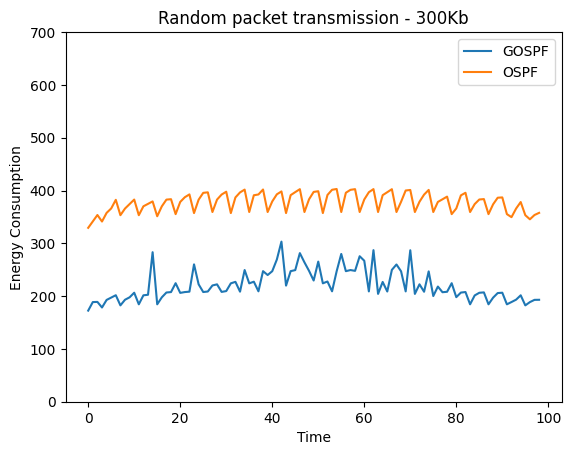

In [14]:
plt.ylim(0, 700)
plt.plot(energy_data[1:], label="GOSPF")
plt.plot(ospf_energy_data[1:], label="OSPF")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.legend()
plt.title("Random packet transmission - 300Kb")

Text(0.5, 1.0, 'Random packet transmission - 300Kb')

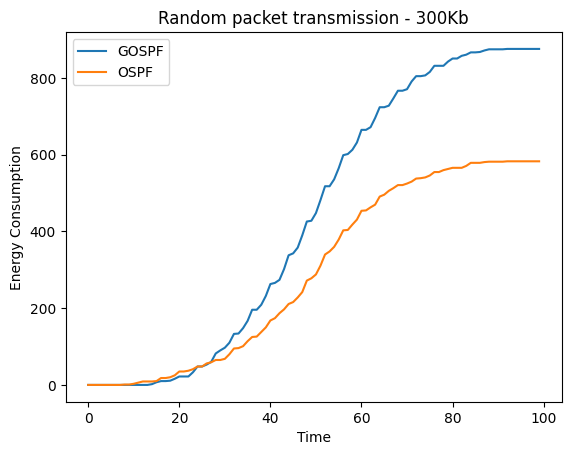

In [15]:
plt.plot(gospf_dropped, label="GOSPF")
plt.plot(ospf_dropped, label="OSPF")
plt.xlabel("Time")
plt.ylabel("Cumulative Dropped Packets")
plt.legend()
plt.title("Random packet transmission - 300Kb")

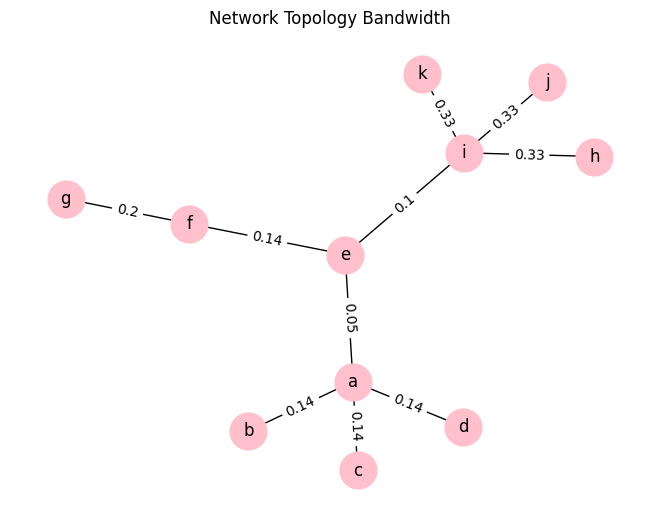

In [29]:
G = net.get_active_network_state()
for edge in G.edges(data=True):
    G.edges[edge[0], edge[1]]['cost'] = round(G.edges[edge[0], edge[1]]['cost'], 2)
pos = nx.spring_layout(G)  # Define node positions using a spring layout
nx.draw(G, pos, with_labels=True, node_size=700, node_color="pink")  # Draw nodes
labels = nx.get_edge_attributes(G, 'cost')  # Get edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, )  # Draw edge labels
plt.title("Network Topology Bandwidth")
plt.show()

In [ ]:
class Router:
    def __init__(self, id, G):
        self.id = id # String identifier
        self.link_state_db = G # For simplicity, assume each router start with a converged topo
        self.sleep = False # Eco-router sleep status for GOSPF

        self.packet_dest= {} # Destinations being sent packets originated from this router
        self.packet_loss= 0

    def calc_cost(self):
        # Define link cost as ref_bandwidth / (bandwidth - usage)
        for u, v, data in G.edges(data=True):
            if data['band'] - data['usage'] == 0:
                data['cost'] = float('inf')
            else:
                data['cost'] = ref_bandwidth / (data['band'] - data['usage'])
         
    def plot_ls_db(self):
        self.calc_cost()
        # Plot the graph with cost
        np.random.seed(20)
        
        pos = nx.spring_layout(self.link_state_db)  # Define node positions using a spring layout
        nx.draw(self.link_state_db, pos, with_labels=True, node_size=700, node_color="lightblue")  # Draw nodes
        labels = nx.get_edge_attributes(self.link_state_db, 'cost')  # Get edge weights as labels
        nx.draw_networkx_edge_labels(self.link_state_db, pos, edge_labels=labels)  # Draw edge labels
        plt.title(f"Link State Database of Router {self.id} with Costs")
        plt.show()

    def randomize_packet_dest(self, pkt_count):
        self.packet_dest = {}
        for pkt in range(pkt_count):
            random_id = random.choice([item for item in router_ids if item != self.id])
            if random_id in self.packet_dest:
                self.packet_dest[random_id] += 1
            else:
                self.packet_dest[random_id] = 1

    def send_packets(self):
        # Compute shortest path using Djikstra algorithm
        def get_path(target_id):
            return nx.shortest_path(self.link_state_db, source=self.id, target=target_id, weight='cost')
        
        self.calc_cost()
        self.packet_loss = 0
        for dest in self.packet_dest:
            path = get_path(dest)
            path_avail = True
            for u, v in zip(path[:-1], path[1:]):
                if G[u][v]['usage'] >= G[u][v]['band']:
                    print(f"Max usage: {dest} unreachable from {self.id}")
                    self.packet_loss += 1
                    path_avail = False
                    break
            
            if path_avail:
                for u, v in zip(path[:-1], path[1:]):
                    G[u][v]['usage'] += 1
                print(f"Sending packet: {self.id} to {dest}")

In [ ]:
# Basic OSPF

random.seed(20)
reset_usage()

for id in router_ids:
    routers[id] = Router(id, G)
    if random.random() < 0.3:
        routers[id].randomize_packet_dest(2)
        routers[id].send_packets()

routers['A'].plot_ls_db()
plot_topo()

In [ ]:
#GOSPF
